




# Medical Appointment No Shows 
### *GHAIDA S. ALTUWAIJRI*
### *May 21, 2020*


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#bibliography">Bibliography</a></li>    
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments inBrazil and is focused on the question of whether or not patients showup for their appointment. A number of characteristics about the patient are included in each row.
- ‘ScheduledDay’ tells us on what day the patient set up their appointment.
- ‘Neighborhood’ indicates the location of the hospital.
- ‘Scholarship’ indicates whether or not the patient isenrolled in Brasilian welfare program Bolsa Família.
- the last column says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up

On this project, we aimed to explore the 'Medical Appointment No Shows' dataset from Kaggle and finding answers for these questions:
- what is the percentage of attending or not attending the appointments?
- which gender have more commitment to attend the appointment?
- Does age affect the attendance of appointments?
- Is sending reminder messages help the patient to remember and attend the appointments?
- Is scheduling the appointment long time before will affect attending?
- What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import csv
from datetime import datetime as dt
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [4]:
#loading the dataset 
nsa = pd.read_csv('NoShowAppointments-kagglev2-may-2016.csv' , \
                        parse_dates=['ScheduledDay', 'AppointmentDay']) 

In [5]:
nsa.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
#Removing the Unneeded columns
columns = ['Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']
nsa.drop(columns, inplace=True, axis=1)

In [7]:
# Rename for 'No-show', 'SMS_received' and 'NoShow'.
nsa.rename(columns={ 'No-show' : 'NoShow' }, inplace = True) 
nsa.rename(columns={ 'SMS_received' : 'SMSReceived' }, inplace = True) 
nsa.rename(columns={ 'NoShow' : 'Show' }, inplace = True) 

In [8]:
# Removing the time from 'ScheduledDay' and 'AppointmentDay'
nsa['AppointmentDay'] = pd.to_datetime(nsa['AppointmentDay']).dt.date
nsa['ScheduledDay'] = pd.to_datetime(nsa['ScheduledDay']).dt.date

# Creating new column with deference between 'ScheduledDay' and AppointmentDay.
SAdifferents = nsa["AppointmentDay"] - nsa["ScheduledDay"]
nsa["ScheduledToAppointment"] = SAdifferents
# Convert the new column to integer type.
nsa['ScheduledToAppointment'] = pd.to_numeric(nsa['ScheduledToAppointment'].dt.days, downcast='integer')

In [9]:
# For the show column, We will replace No with 1 and yes with 0, And covert it to integar type.
nsa['Show'] = nsa['Show'].replace( 'No', 1)
nsa['Show'] = nsa['Show'].replace( 'Yes', 0)
nsa.Show = nsa.Show.astype(int)

In [10]:
nsa.dtypes

PatientId                 float64
AppointmentID               int64
Gender                     object
ScheduledDay               object
AppointmentDay             object
Age                         int64
SMSReceived                 int64
Show                        int64
ScheduledToAppointment      int16
dtype: object

In [11]:
# Changing the types of 'PatientId' and 'AppointmentID' to String
nsa.PatientId = nsa.PatientId.astype(str)
nsa.AppointmentID = nsa.AppointmentID.astype(str)

In [12]:
nsa.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,SMSReceived,Show,ScheduledToAppointment
0,29872499824296.0,5642903,F,2016-04-29,2016-04-29,62,0,1,0
1,558997776694438.0,5642503,M,2016-04-29,2016-04-29,56,0,1,0
2,4262962299951.0,5642549,F,2016-04-29,2016-04-29,62,0,1,0
3,867951213174.0,5642828,F,2016-04-29,2016-04-29,8,0,1,0
4,8841186448183.0,5642494,F,2016-04-29,2016-04-29,56,0,1,0
5,95985133231274.0,5626772,F,2016-04-27,2016-04-29,76,0,1,2
6,733688164476661.0,5630279,F,2016-04-27,2016-04-29,23,0,0,2
7,3449833394123.0,5630575,F,2016-04-27,2016-04-29,39,0,0,2
8,56394729949972.0,5638447,F,2016-04-29,2016-04-29,21,0,1,0
9,78124564369297.0,5629123,F,2016-04-27,2016-04-29,19,0,1,2


In [13]:
nsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   PatientId               110527 non-null  object
 1   AppointmentID           110527 non-null  object
 2   Gender                  110527 non-null  object
 3   ScheduledDay            110527 non-null  object
 4   AppointmentDay          110527 non-null  object
 5   Age                     110527 non-null  int64 
 6   SMSReceived             110527 non-null  int64 
 7   Show                    110527 non-null  int64 
 8   ScheduledToAppointment  110527 non-null  int16 
dtypes: int16(1), int64(3), object(5)
memory usage: 7.0+ MB


In [14]:
nsa.nunique() 

PatientId                  62299
AppointmentID             110527
Gender                         2
ScheduledDay                 111
AppointmentDay                27
Age                          104
SMSReceived                    2
Show                           2
ScheduledToAppointment       131
dtype: int64

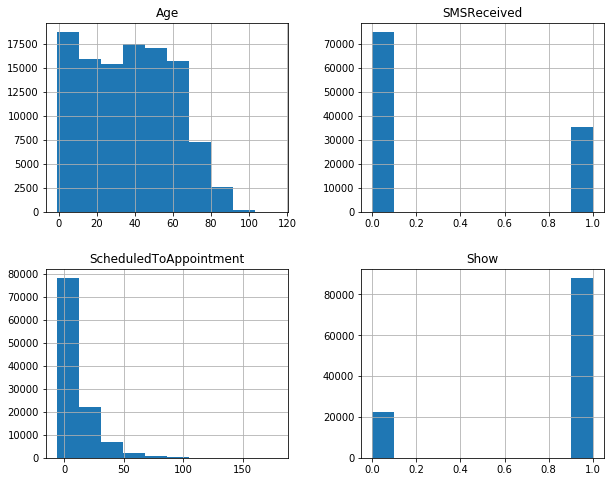

In [15]:
nsa.hist(figsize=(10,8));

### Checking if there is any wrong or missing data

In [16]:
#check if there is any NaN values in our dataset
show_null = nsa.isnull().sum() 
show_null

PatientId                 0
AppointmentID             0
Gender                    0
ScheduledDay              0
AppointmentDay            0
Age                       0
SMSReceived               0
Show                      0
ScheduledToAppointment    0
dtype: int64

In [17]:
#check if there is any zero ages 
show_zero = nsa['Age'][(nsa[['Age']] == 0).all(axis=1)]  
show_zero

59        0
63        0
64        0
65        0
67        0
         ..
110345    0
110346    0
110454    0
110460    0
110507    0
Name: Age, Length: 3539, dtype: int64

In [18]:
#check if there is very old ages
show_old = nsa['Age'][(nsa[['Age']] > 100).all(axis=1)] 
show_old

58014    102
63912    115
63915    115
68127    115
76284    115
90372    102
97666    115
Name: Age, dtype: int64

In [19]:
#check if there is any minus ages 
show_minus = nsa['Age'][(nsa[['Age']] < 0).all(axis=1)] 
show_minus

99832   -1
Name: Age, dtype: int64

In [20]:
#check if there is any minus days between Scheduled day and Appointment day
nsa['ScheduledToAppointment'][(nsa[['ScheduledToAppointment']] < 0).all(axis=1)]

27033   -1
55226   -1
64175   -1
71533   -6
72362   -1
Name: ScheduledToAppointment, dtype: int16

in this part of our project we load and discoverd the data, check for cleanliness, and then trim and clean our dataset for analysis.

### Doing some calculations for 'NoShow' , 'Gender' and 'SMSReceived' columns.

In [21]:
# returning a number of patints who shows and who did not (did use it)
showing_counts = nsa["Show"].value_counts()
show_counts = showing_counts[1] 
no_show_counts = showing_counts[0] 

# returning a table with patints who shows or who did not
didshow= nsa [nsa.Show == True]
did_not_show= nsa [nsa.Show == False]

# creating masks with patints who shows or who did not
didNotShow = nsa.Show == False
didShow = nsa.Show == True

In [22]:
# returning a number of males and females 
gender_counts = nsa["Gender"].value_counts()
female_counts = gender_counts['F']
male_counts = gender_counts['M']

# returning a table with only males or only females
male_gender = nsa [nsa["Gender"] == ('M')]
female_gender = nsa [nsa["Gender"] == ('F')]

In [23]:
# returning a total number of receiving SMS or not 
SMS_counts = nsa["SMSReceived"].value_counts()
one_counts = gender_counts[1]
zero_counts = gender_counts[0]

# returning a table with males or females only
didNotReceived = nsa [nsa["SMSReceived"] == (0)]
didReceived = nsa [nsa["SMSReceived"] == (1)]

In the above set of code cells, We did some calculations on the 'NoShow' column by counting the number of patients who shows and who did not. also, returning new separate tables for only the patients who show or only who did not.

We did the same for the 'Gender' and 'SMSReceived' columns, so we count the total number for each value and returning new separate tables for these values.

### Data Cleaning

#### Replacing the Zero and Minus ages with the age mean

In [24]:
age_mean = nsa['Age'].mean() # find the 'Age' mean 
age_mean = (round(age_mean)) # convert the mean to the nearest integer 
print(age_mean) 

37


In [25]:
nsa['Age'] = nsa['Age'].replace( 0, age_mean) #replace the 0 values to the age_mean
nsa['Age'] = nsa['Age'].replace( -1, age_mean) #replace the -1 value to the age_mean

In [26]:
nsa.loc[ 99832 , : ] # check if the minus value changed 

PatientId                 465943158731293.0
AppointmentID                       5775010
Gender                                    F
ScheduledDay                     2016-06-06
AppointmentDay                   2016-06-06
Age                                      37
SMSReceived                               0
Show                                      1
ScheduledToAppointment                    0
Name: 99832, dtype: object

In [27]:
nsa['Age'][(nsa[['Age']] == 0).all(axis=1)]  #check if there is any zero ages 

Series([], Name: Age, dtype: int64)

#### Replacing the Minus values for 'ScheduledToAppointment' with it's mean

In [28]:
days_mean = nsa['ScheduledToAppointment'].mean() # find the 'ScheduledToAppointment' mean 
days_mean = days_mean.astype(int) # convert the mean to integer 
print(days_mean) 

10


In [29]:
#replace the -1 value to the days_mean
nsa['ScheduledToAppointment'] = nsa['ScheduledToAppointment'].replace( [-1, -6], days_mean)

In [30]:
# check if the minus value changed 
nsa['ScheduledToAppointment'][(nsa[['ScheduledToAppointment']] < 0).all(axis=1)]

Series([], Name: ScheduledToAppointment, dtype: int64)

After discussed the structure of the data and the problems that need to be cleaned, we performed those cleaning steps in the above part.

<a id='eda'></a>
## Exploratory Data Analysis


In the exploration part, After trimmed and cleaned our data we will Compute statistics and create visualizations with the goal of addressing the following research questions.

##### Getting a Visual Representation of the Correlation Matrix using Seaborn and Matplotlib

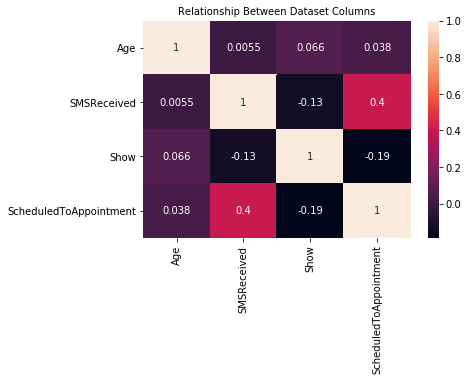

In [41]:
def histogram_intersection(df):

    corrMatrix = df.corr()

    sn.heatmap(corrMatrix, annot=True)
    plt.title("Relationship Between Dataset Columns", y=1.02, fontsize=10);
    v = plt.show()
    return v


histogram_intersection(nsa)

This scatter plot or correlation matrix is to show the relationship between Age, SMSReceived, Show and ScheduledToAppointment.

### What is the ***percentage*** of attending or not attending the appointments?

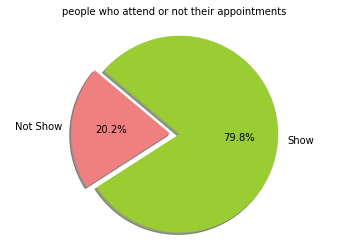

In [31]:
# Data to plot
labels = 'Not Show', 'Show'
sizes = [no_show_counts, show_counts]
colors = ['lightcoral', 'yellowgreen']
explode = (0.1, 0 )  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title("people who attend or not their appointments", y=1.02, fontsize=10);
plt.axis('equal')
plt.show()

this pie-chart shows the percentage of attending the appointments or not, and we notice that there is ***20.2%*** of patients didn't show on the appointments and ***79.8%*** for the people who attend. the next charts will illustrate not attending these appointments and find a solutions for that or predict the people who will not attend in the future.

### Which gender have more commitment to attend the appointment?

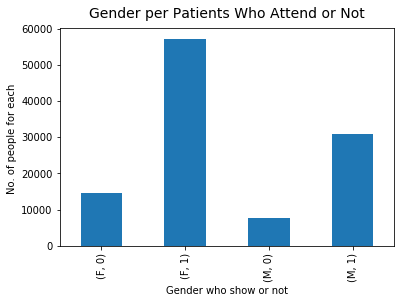

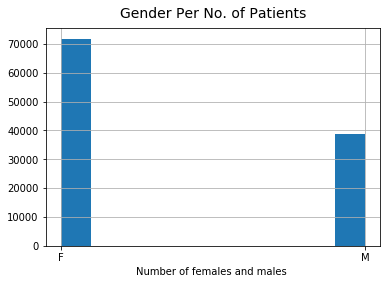

In [32]:
showToGender = nsa.groupby(['Gender', 'Show']).size().plot(kind='bar',stacked=False)
showToGender.set_xlabel("Gender who show or not")
showToGender.set_ylabel("No. of people for each ")
plt.title("Gender per Patients Who Attend or Not", y=1.02, fontsize=14)
plt.show()


GenderPerNo = nsa['Gender'].hist(); #there is females more that males
GenderPerNo.set_xlabel("Number of females and males ")
plt.title("Gender Per No. of Patients", y=1.02, fontsize=14)
plt.show()

The above graph shows that the number of females is greater than males. So we will compare between the (f, 1) which is the females did show and (f, 0) which is the female who did not show, and the same for (M, 1) and (M, 0).

We notice that **Females are more committed than males**, And that is because of the number of females who show almost four times bigger than females who did not show. And for males who show only three times bigger than those who did not.

### Does age affect the attendance of appointments?

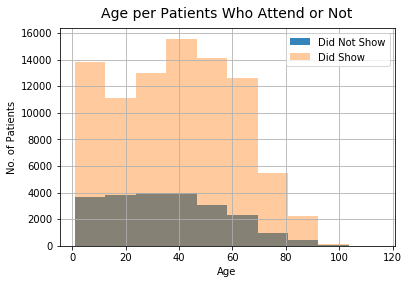

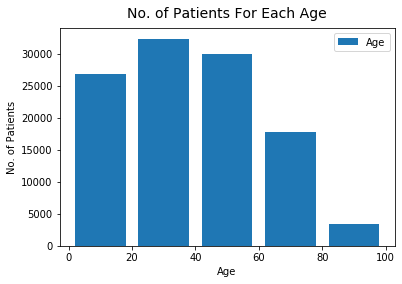

In [33]:
showToAge = nsa.Age[didNotShow].hist(alpha=0.9 ,label='Did Not Show')
showToAge = nsa.Age[didShow].hist(alpha=0.4 ,label='Did Show')
showToAge.set_xlabel("Age")
showToAge.set_ylabel("No. of Patients")
plt.title("Age per Patients Who Attend or Not", y=1.02, fontsize=14)
plt.legend();


# the Age deferences histogram 
PeoplePerAge = nsa[['Age']].plot( kind='hist',bins=[0,20,40,60,80,100],rwidth=0.8) 
PeoplePerAge.set_xlabel("Age")
PeoplePerAge.set_ylabel("No. of Patients")
plt.title("No. of Patients For Each Age", y=1.02, fontsize=14)
plt.show()

The first chart shows that **Age is an affecting factor for the attending appointments**. As seen for the second graph,we have a different number of people per each age. but we can notice that the kids between 0-12years are showing on appointments more than people between 12-23. and people between 35-46 are committed more than between 23-35 on attending their appointments.

### Is sending reminder messages helps the patient to remember and attend the appointments?

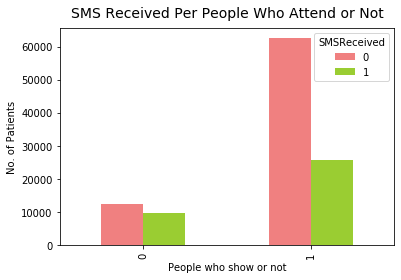

In [34]:
#the SMS Recived histogram
sizes = ['Show']
colors = ['lightcoral', 'yellowgreen']
ShowToSMS = nsa.groupby(['Show', 'SMSReceived']).size().unstack().plot( kind='bar', color=colors )
ShowToSMS.set_xlabel("People who show or not")
ShowToSMS.set_ylabel("No. of Patients")
plt.title("SMS Received Per People Who Attend or Not", y=1.02, fontsize=14)
plt.show()

In [35]:
nsa.groupby(['Show', 'SMSReceived']).size().unstack()

SMSReceived,0,1
Show,,
0,12535,9784
1,62510,25698


This bar graph illustrates the relation between receiving messages and attending appointments. The 0 values in the X axis represent people who didn't show and 1 for people who show. We know that number of people who received 0 messages is more that who received 1. In this case, we will answer our question by comparing the people who don't show and people who show separately. So for the people who show there is a bigger difference between who received 1 and 0 message. And for the people who don't show it almost the same between who received message or not, So the answer is: **receiving SMS doesn't positively affect showing on appointments**.

### Is scheduling the appointment long time before will affect attending?

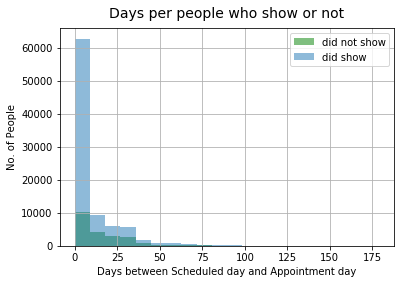

In [36]:
showSMS = nsa.ScheduledToAppointment[didNotShow].hist(alpha=0.5, bins=20 ,label='did not show', color='green')
showSMS = nsa.ScheduledToAppointment[didShow].hist(alpha=0.5,  bins=20 ,label='did show')
showSMS.set_xlabel("Days between Scheduled day and Appointment day")
showSMS.set_ylabel("No. of People")
plt.title("Days per people who show or not", y=1.02, fontsize=14)
plt.legend();

This histogram shows that most of the people scheduled their appointment very short time before it's date, And it's cleared by the chart that most people attend their appointments when they scheduled it on the same day of the appointment and vise versa if they sceduled a long time before.

So, our answer is YES

### What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

by doing the above calculations and visualizations, we came up that we can predict if a patient will show up for their scheduled appointment by ***Scheduling Date, Age, and Gender*** factors.

And now, we answered all of our questions by computed some statistics and created visualizations to make it easier to understand for all people.

<a id='conclusions'></a>
## Conclusions

In conclusions, We found the main factors that affect patient show up by wrangling the data, Also, We encounter some limits on data usability when we first obtain it like wrong and missing values and we solved that by cleaning the data and finally we moved to explore our data by answering 6 of our questions and creating visualizations for them.

### Limitations

there is a few limitations of our dataset:

- It would be interisting if there is a column for reviw or rate for the previos appointment.
- It would be more accurate if the appointment time provided with appointment data.
- It would be interisting if we know the individual education for each appointment.

<a id='bibliography'></a>
## Bibliography

[1] https://www.udacity.com/

[2] https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html
